# Annotate cell labels to objects

If running from terminal, use below cell

In [1]:
import sys

min_radius, min_z_radius = list(map(float, sys.argv[1:3]))
# suffix = sys.argv[3]
suffix = '_objects'
# suffix = '_labeled_blobstack_v4'

out_suffix = '_cells'

print(f"Initiating annotation software ...\nWe're looking for files with the suffix {suffix + '.csv'} \nand we will be selecting on a minimum radius of {min_radius} pixels and a minimum of {min_z_radius} of planes in which we detected a 'blob'")

ValueError: could not convert string to float: '-f'

If running from jupyter notebook, run below instead

In [1]:
suffix = '_objects'
min_radius, min_z_radius = (8, 3)
out_suffix = '_cells'

# print(f"Initiating annotation software ...\nWe're looking for files with the suffix {suffix + '.csv'} \nand we will be selecting on a minimum radius of {min_radius} pixels and a minimum of {min_z_radius} of planes in which we detected a 'blob'")min_radius, min_z_radius = list(map(float, sys.argv[1:3]))

In [2]:
# Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install lxml_html_clean

In [3]:
## general math and system modules/functions
from math import sqrt
import numpy as np
import os
import glob
import itertools
import tkinter as tk
import os, sys, scipy, tkinter, fnmatch
from tkinter import *
from tkinter import filedialog, messagebox

## data formatting!
import pandas as pd

## image import and processing module functions
import czifile as cfile
from skimage import data, data, measure, exposure
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
import cv2 as cv
import PIL
import imageio, glob, PIL
from PIL import Image, ImageFilter, ImageDraw
from scipy.spatial.distance import pdist, squareform

## 
import napari

## plotting modules
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.pyplot import Axes



## 1. generate an inverted maximum intensity projection for identifying

For each imstack, store image meta data (immeta):
1. image **file path**
1. **image** inverted mean intensity projection
1. **array** of **max intensity values and coordinates** for all blobs

In [4]:
# generate an inverted mean intensity projection (imip) + some metadata - DO NOT USE FOR QUANTIFICATION!
# def generate_imip(filepath, imstack, max_intensities_df):
#     # inverted mean intensity projection - DO NOT USE FOR QUANTIFICATION!
#     return([os.path.basename(filepath), np.max(imstack) - np.mean(imstack, axis=0), max_intensity_df])

# plot this imip with the blobs indicated -- this is to be used within a script (and IDE)
def plot_imip(imip):
    ## initiate subplots
    fig, axes = plt.subplots(1, 1)
    
    ## normalize intensities
    rel_Is = [x/np.max(list(imip[2]['I'])) for x in list(imip[2]['I'])]
    for i, index in enumerate(imip[2].index):
        x, y, lbl, area, r = imip[2].loc[index, np.array(['x', 'y', 'ID', 'area', 'r'])]
#         print(f'Iteration {i}: x = {x}, y = {y}, lbl = {lbl}, area = {area}, r = {r}')
    #     color = 'red' if area > np.pi*r_min**2 else 'black'

            # if you like to plot, use below code on an image
        plt.text(y = y, x = x, s = '+', color = 'black', fontsize = 'small', horizontalalignment='center',
         verticalalignment='center')
    #     ## plot the blob + a margin
        c = plt.Circle((x, y),  r*1.6, color= 'black', linewidth=.3, linestyle = '--', fill=False)
        axes.add_patch(c)

    axes.imshow(imip[1], cmap = 'gray')
    # axes.set_axis_off()

    plt.tight_layout()
    plt.show()

## 2. Label cells by hand

In [5]:
from datetime import datetime;
from tkinter import *
import win32gui

# now gather cell labels
def label_cells_in_imip(imip):
    windowname = str(datetime.now()) + f' -- {imip[0]}'

    ## average the grayscale intensity values per pixel
    imipb = (imip[1] - np.min(imip[1]))/(np.max(imip[1]  - np.min(imip[1])))
#     imipb = imip[1]
    
    # function to display the coordinates of 
    # of the points clicked on the image  
    def click_event(event, x, y, flags, params): 
        # checking for left mouse clicks 
        if event == cv.EVENT_LBUTTONDOWN: 
            # displaying on the window 
            cv.circle(img,(x,y),5,(0,250,0), 2)
            cv.imshow(windowname, img)

            # create a window to enter variable name 
            root = Tk()
            root.wm_attributes('-topmost', 1)
            win32gui.SetForegroundWindow(root.winfo_id())
            
            Label(root, text = 'label').grid(row = 3, column = 2)
            cell = Entry(root)
            cell.grid(row = 3, column = 3)
            cell.focus_set()

            def globlabel(event):
                print("Enter blob label")
                global Cell
                Cell = str(cell.get())

                root.quit()

            def cancellabel():
                global Cell
                Cell = 'NA'

                root.quit()

            root.bind('<Return>', globlabel)

            okbutton = Button(root, text='Save', command=globlabel)
            okbutton.bind('<Button-1>', globlabel)
            okbutton.grid(row=5, column=4, sticky=W, pady=4)

            Button(root, text='Cancel', command=cancellabel).grid(row=5, column=5, sticky=W, pady=4)
            
            root.mainloop()

            root.destroy()

            # add label to labels list
            labels.append((x, y, str(Cell)))
            cv.putText(img,str(Cell),(x,y), 2, 1, (0,255,0), thickness = 2)
            cv.imshow(windowname, img)

    # driver function 
    global labels
    labels = list()

    img = imipb

    # displaying the image 
    cv.namedWindow(windowname, cv.WINDOW_NORMAL) 
    cv.imshow(windowname, img)
    cv.resizeWindow(windowname, 700, 700) 
    
    ## normalize intensities
    rel_Is = [x/np.max(list(imip[2]['I'])) for x in list(imip[2]['I'])]
    for i, label in enumerate(imip[2].ID):
        # ['ID', 'x', 'y', 'r_x', 'r_y', 'z', 'r_z', 'I.mean', 'I.sd', 'bg', 'nr.pxls', 'blob_ID', 'r']
        x, y, r, I, ID = np.array(imip[2].loc[i, np.array(['x', 'y', 'r', 'I', 'ID'])])
        rel_I = rel_Is[i]
        cv.circle(img, (int(x),int(y)), int(r), (0, 50, 100), 1)
        cv.imshow(windowname, img)

    # setting mouse handler for the image 
    # and calling the click_event() function 
    cv.setMouseCallback(windowname, click_event) 

    # wait for a key to be pressed to exit 
    cv.waitKey(0) 

    # close the window 
    cv.destroyAllWindows() 
    
    #return the labels
    return(pd.DataFrame(labels, columns = ['x', 'y', 'label']))

def check_labels(imip, labels):
    windowname = str(datetime.now()) + f' -- Are you content?'
    
    def happy():
        root = tk.Tk()
        root.title("ARE YOU HAPPY?")
        root.wm_attributes('-topmost', 1)
        win32gui.SetForegroundWindow(root.winfo_id())
            
        tk.Label(root, text = 'Are you happy?').grid(row = 1, column = 1)

        def yes_happy(event):
            global happy
            happy = True

            root.destroy()
            root.quit()

        def no_unhappy():
            global happy
            happy = False

            root.destroy()
            root.quit()

        root.bind('<Return>', yes_happy)

        happybutton = tk.Button(root, text='Yes', command = yes_happy)
        happybutton.bind('<Button-1>', yes_happy)
        happybutton.grid(row=3, column=2, sticky=tk.W, pady=4)
        
        tk.Button(root, text='NO!', command=no_unhappy).grid(row=3, column=3, sticky=tk.W, pady=4)

        tk.mainloop()
    
    ## average the grayscale intensity values per pixel
    img = (imip[1] - np.min(imip[1]))/(np.max(imip[1] - np.min(imip[1])))
#  img = imip[1]
    
    # displaying the image 
    cv.namedWindow(windowname, cv.WINDOW_NORMAL) 
    cv.imshow(windowname, img)
    cv.resizeWindow(windowname, 700, 700) 
    
    labels = np.array(labels)
    ## normalize intensities
    for cell in labels:
        x, y, label = cell
        cv.circle(img, (int(x),int(y)), 20, (0, 255, ), 1)
        cv.putText(img,str(label),(x-25,y-25), 2, 1, (0,255,0), thickness = 2)
        cv.imshow(windowname, img)
    
    # make your choice
    happy()
    
    # close the window 
    cv.destroyAllWindows() 
    

## 3. Add labels to data

In [6]:
## function to format czi file that you read in
def readczi(filepath):
    img = cfile.imread(filepath)
    return(img[0, 0, :img.shape[2], :img.shape[3], :img.shape[4], 0])

## function to format/create imip
def generate_imip(filepath, min_radius):
    ## trace back czi file path
    im_filepath = filepath[:-len(suffix + '.csv')] + '.czi'

    ## read in czi file
    imstack = readczi(im_filepath)
    
    ## 
    max_Idf = pd.read_csv(filepath).drop('Unnamed: 0', axis = 1)
    
    max_Idf = max_Idf[max_Idf['ID'].isin(max_Idf.ID[max_Idf['r'] >= min_radius])] ## 
    # inverted mean intensity projection - DO NOT USE FOR QUANTIFICATION!
    
    max_Idf.index = range(0, len(max_Idf.index))
    
    
    return([os.path.basename(im_filepath), np.max(imstack) - np.max(imstack, axis=0), max_Idf])

## function to merge blob coordinates (cells) with cell labels
def add_cell_labels(imip, labels_df, max_disp = 10):
    max_Idf = imip[2]
    
    #
    data = max_Idf
    data = data[['x', 'y', 'ID']]

    # make a distance matrix with the cells label coordinates as rows and the blobs as columns
    dist_df = pd.concat([data, labels_df])
    dist =  squareform(pdist(dist_df.iloc[:, 0:2]))

    # indices of the blobs
    blob_ids = list(range(0, len(dist_df)))[:data.shape[0]]
    # indices of the cell labels
    cell_ids = list(range(0, len(dist_df)))[data.shape[0]:]

    # subset distance matrix to hold the relevant distances
    dist = dist[np.ix_(cell_ids, blob_ids)]

    # initiate a dictionary to store cell-label pairs
    cell_label_dict = {}
    # define a function to return blob labels that correspond with cell labels that are as close enough and closest to the labeled coordinates
    for i, cell in enumerate(list(labels_df['label'])):
        # for each labelled cell
        sub = dist[i] # fetch the distances from the blobs
        sub = dist[i] # fetch the distances from the blobs
        blob_index = np.where([overlaps and closest for overlaps, closest in zip((sub <= max_disp), (sub == np.min(sub)))])[0]
        if len(blob_index) > 0:
            # data.index[
            blob_label = data.ID[data.index[blob_index[0]]]
            cell_label_dict[int(blob_label)] = cell # add the cell label to the blob label entry in a dictionary

    out = max_Idf[max_Idf['ID'].isin(cell_label_dict.keys())] # subset data for the labelled cells
    out.insert(0, 'cell', list(map(lambda x: cell_label_dict.get(x), out['ID'])))
    return(out)

def save_labelled_tiff(imip):
    ## open labels file
    filepath = folder + '/' + imip[0][:-4] + out_suffix + '.csv'
    labels = pd.read_csv(filepath).drop('Unnamed: 0', axis = 1)

    ## initiate subplots
    fig, axes = plt.subplots(1, 1)

    ## normalize intensities
    rel_Is = [x/np.max(list(imip[2]['I'])) for x in list(imip[2]['I'])]
    for i, cell in enumerate(labels.cell):
        cell, x, y, r, I = labels.loc[i, np.array(['cell', 'x', 'y', 'r', 'I'])]
        rel_I = rel_Is[i]
        c = plt.Circle((x, y), r*1.2, color= 'black', linewidth=1, linestyle = '--', fill=False)
        axes.add_patch(c)

        if ((y - r*2) > 0):
            plt.text(x, y - r*2, cell, fontsize = 'small', horizontalalignment='center',
             verticalalignment='center')
        else:
            plt.text(x, y + r*2, cell, fontsize = 'small', horizontalalignment='center',
             verticalalignment='center')

    axes.imshow(imip[1], cmap = 'gray')
    axes.set_axis_off()

    plt.tight_layout()

    figname = folder + '/' + imip[0][:-4] + '-labelled_v5.tiff'
    plt.savefig(figname, dpi = 800, format = 'tiff', bbox_inches ='tight')

#     plt.show()

## 4. Iterate over all files

In [9]:
## fetch folder and files:
root = tk.Tk()
root.wm_attributes('-topmost', 1)
root.withdraw()   # this supress the tk window
folder = filedialog.askdirectory(parent = root)

# suffix = '_labeled_blobstack_v4'

files = glob.glob(folder + '/*' + suffix + '.csv')

   >>> initialising Napari viewer

#Processing file D:/Confocal images/Zeiss/Zeiss/PHX6290 (snet-1_H2B)/20230220/Control/21% O2/python_test\20230220_PHX6290 cntr_21%_2_objects.csv
>>> Found 108 potential nuclei
   >>> closing Napari viewer...
   >>> finished analysis, you can find your files in D:/Confocal images/Zeiss/Zeiss/PHX6290 (snet-1_H2B)/20230220/Control/21% O2/python_test


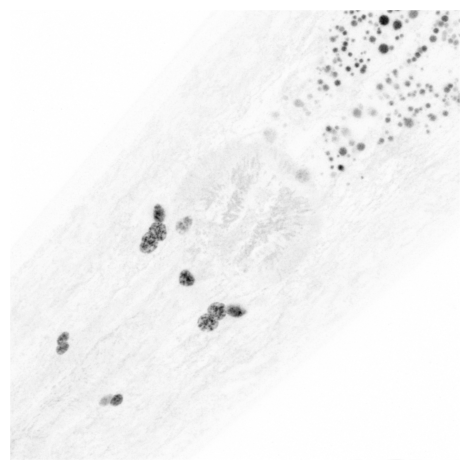

In [10]:
## initialize napari
print('   >>> initialising Napari viewer')
Viewer = napari.Viewer()

for i, file in enumerate(files):
    imip = generate_imip(file, min_radius = min_radius)
    print(f'\n#Processing file {file}\n>>> Found {len(imip[2])} potential nuclei')
    
    ## open the image in napari
    imstack = readczi(file[:-len(suffix + '.csv')] + '.czi')
    Viewer.add_image(imstack, colormap= 'gray_r')
            
#     plot_imip(imip)
    
    if len(imip[2]) > 0:
        ## set a global happy variable that indicates whether you're happy
        global happy
        happy = False
        ## as long as happy is false, label cells, and do it again if you weren't happy 
        while happy == False:
            labels = label_cells_in_imip(imip)
            check_labels(imip, labels)
        out = add_cell_labels(imip, labels, max_disp = 10)

        ## save as .csv file
        out_filename = folder + '/' + os.path.basename(file)[:-len(suffix + '.csv')] + out_suffix + '.csv'
        out.to_csv(out_filename)

        ## save labelled image as tiff
        save_labelled_tiff(imip)
        
    else:
        print(f'### found no neurons in stack {file}')
 
print(f'   >>> closing Napari viewer...')
Viewer.close_all()

print(f'   >>> finished analysis, you can find your files in {folder}')